# 영업 성공 여부 분류 경진대회

## 1. 데이터 확인

### 필수 라이브러리

In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

### 데이터 셋 읽어오기

In [38]:
df_train = pd.read_csv("train.csv") # 학습용 데이터
df_test = pd.read_csv("submission.csv") # 테스트 데이터(제출파일의 데이터)

In [39]:
print(df_train.isna().sum()/len(df_train))

bant_submit                0.000000
customer_country           0.016560
business_unit              0.000000
com_reg_ver_win_rate       0.754330
customer_idx               0.000000
customer_type              0.741345
enterprise                 0.000000
historical_existing_cnt    0.768023
id_strategic_ver           0.941921
it_strategic_ver           0.981096
idit_strategic_ver         0.923017
customer_job               0.315908
lead_desc_length           0.000000
inquiry_type               0.015869
product_category           0.326717
product_subcategory        0.844264
product_modelname          0.844365
customer_country.1         0.016560
customer_position          0.000000
response_corporate         0.000000
expected_timeline          0.520464
ver_cus                    0.000000
ver_pro                    0.000000
ver_win_rate_x             0.689421
ver_win_ratio_per_bu       0.741918
business_area              0.689421
business_subarea           0.906811
lead_owner                 0

In [40]:
# 지역 코드에 따른 지역명 매핑
region_mapping = {
    "EU": ["LGEAG", "LGECZ", "LGEFS", "LGEDG", "LGEHS", "LGEMK", "LGEIS", "LGESC", "LGEEH", "LGEBN", "LGEWR", "LGEPL", "LGEMA", "LGEPT", "LGERO", "LGEES", "LGENO", "LGESW", "LGEUK"],
    "RC": ["LGEAK", "LGERM", "LGERI", "LGERA", "LGEUR", "LGELV"],
    "MA": ["LGEAS", "LGEEG", "LGELF", "LGESK", "LGEMC", "LGESA", "LGETU", "LGEOT", "LGEDF", "LGEGF", "LGEME", "LGEAF", "LEAO", "LGENI", "LGETK", "LGEAT", "LGESJ", "LGEEF", "LGEYK", "LGEIR"],
    "AP": ["LGEAP", "LGEQA", "LGETL", "LGECH", "LGEYT", "LGETR", "LGETA", "LGESY", "LGESH", "LGEQH", "LGEQD", "LGEPN", "LGENE", "LGEKS", "LGEHZ", "LGEHN", "LGEHK", "LGEIL", "LGEPH", "LGEVH", "LGEKR", "LGESL", "LGEIN", "LGETH", "LGEML", "LGETT", "LGEJP"],
    "NA": ["LGECI", "LGERS", "LGEMX", "LGEMS", "LGEMM", "LGEMR", "LGEUS", "LGEMU", "LGEAI"],
    "LA": ["LGEAG", "LGEBR", "LGECL", "LGEVZ", "LGECB", "LGEPS", "LGEPR", "LGESP", "LGEAR"],
    "OT": ["LGEEB", "LGELA", "LGEBT", "MA", "RC"]
}


def categorize_region(code):
    for region, codes in region_mapping.items():
        if code in codes:
            return region
    return "ETC"

df_train['region'] = df_train['response_corporate'].apply(categorize_region)
df_test['region'] = df_test['response_corporate'].apply(categorize_region)

In [41]:
def extract_country(value):
    if not isinstance(value, str):
        value = str(value)
    match = re.search(r'\/([^\/]+)$', value)
    if match:
        return match.group(1)
    return None

df_train['customer_country'] = df_train['customer_country'].apply(extract_country)
df_test['customer_country'] = df_test['customer_country'].apply(extract_country)

In [42]:
# 언더샘플링 전 타겟 변수 'is_converted'의 분포 확인 및 언더샘플링
target_distribution = df_train['is_converted'].value_counts()
min_samples = target_distribution.min()
df_train_balanced = pd.concat([
    df_train[df_train['is_converted'] == True].sample(min_samples, random_state=42),
    df_train[df_train['is_converted'] == False].sample(min_samples, random_state=42)
], ignore_index=True)
df_train_balanced['is_converted'].value_counts()

True     4850
False    4850
Name: is_converted, dtype: int64

In [43]:
df_train.head()

,bant_submit,customer_country,business_unit,com_reg_ver_win_rate,customer_idx,customer_type,enterprise,historical_existing_cnt,id_strategic_ver,it_strategic_ver,...,expected_timeline,ver_cus,ver_pro,ver_win_rate_x,ver_win_ratio_per_bu,business_area,business_subarea,lead_owner,is_converted,region
0,1.0,Philippines,AS,0.066667,32160,End-Customer,Enterprise,NaN,NaN,NaN,...,less than 3 months,1,0,0.003079,0.026846,corporate / office,Engineering,0,True,AP
1,1.0,Philippines,AS,0.066667,23122,End-Customer,Enterprise,12.0,NaN,NaN,...,less than 3 months,1,0,0.003079,0.026846,corporate / office,Advertising,1,True,AP
2,1.0,India,AS,0.088889,1755,End-Customer,Enterprise,144.0,NaN,NaN,...,less than 3 months,1,0,0.003079,0.026846,corporate / office,Construction,2,True,AP
3,1.0,India,AS,0.088889,4919,End-Customer,Enterprise,NaN,NaN,NaN,...,less than 3 months,1,0,0.003079,0.026846,corporate / office,IT/Software,3,True,AP
4,1.0,India,AS,0.088889,17126,Specifier/ Influencer,Enterprise,NaN,NaN,NaN,...,less than 3 months,0,0,0.003079,0.026846,corporate / office,NaN,4,True,AP


In [44]:
#train_counts = df_train['expected_timeline'].value_counts()
#test_counts = df_test['expected_timeline'].value_counts()
#print(train_counts)
#print('-------------------')
#print(test_counts)

value_counts = df_train_balanced['expected_timeline'].value_counts()
print(value_counts)


less than 3 months                                                                                        3121
3 months ~ 6 months                                                                                        801
more than a year                                                                                           392
6 months ~ 9 months                                                                                        177
9 months ~ 1 year                                                                                          160
                                                                                                          ... 
less than 3 months ,meeting with the customer for the more details and tentative boq will ne 32 and 43       1
he want demo next month at pune - 15 may                                                                     1
november 2022                                                                                                1
g

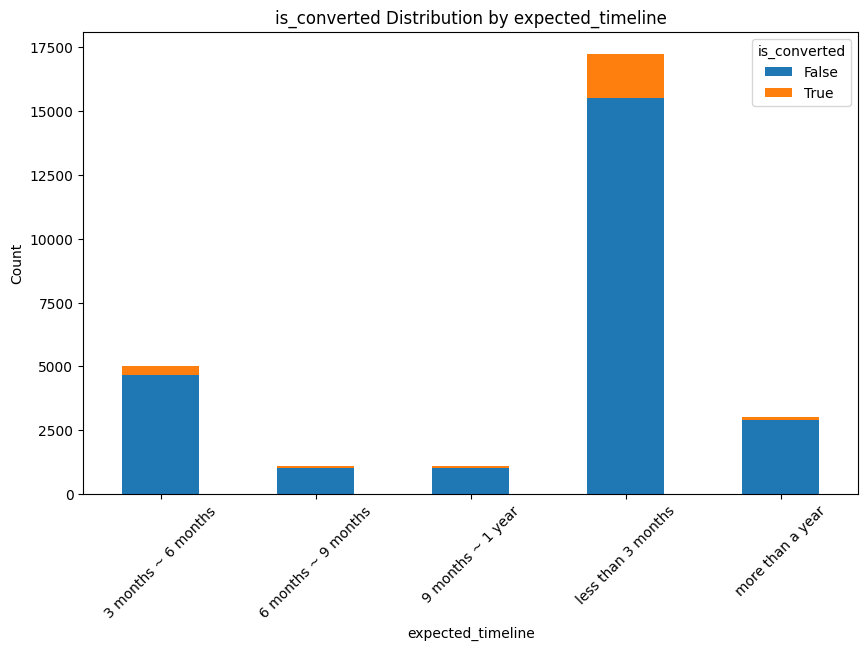

In [45]:
selected_values = ['less than 3 months', '3 months ~ 6 months', 'more than a year', '9 months ~ 1 year', '6 months ~ 9 months']
filtered_df = df_train[df_train['expected_timeline'].isin(selected_values)]

# expected_timeline과 is_converted 간의 교차 탐색 수행
cross_tab = pd.crosstab(filtered_df['expected_timeline'], filtered_df['is_converted'])

# 시각화
cross_tab.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('is_converted Distribution by expected_timeline')
plt.xlabel('expected_timeline')
plt.ylabel('Count')
plt.xticks(rotation=45)  # x축 라벨 회전
plt.legend(title='is_converted')
plt.show()

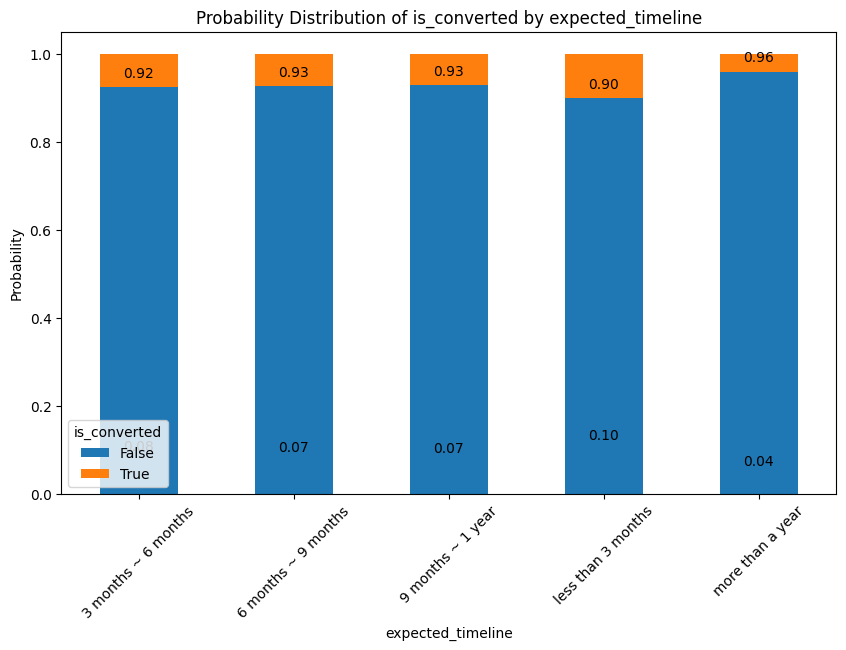

In [46]:
# expected_timeline별로 is_converted의 True와 False의 비율을 계산하여 확률로 나타내기
probabilities = cross_tab.div(cross_tab.sum(axis=1), axis=0)

# 시각화
ax = probabilities.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Probability Distribution of is_converted by expected_timeline')
plt.xlabel('expected_timeline')
plt.ylabel('Probability')
plt.xticks(rotation=45)
plt.legend(title='is_converted')

for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

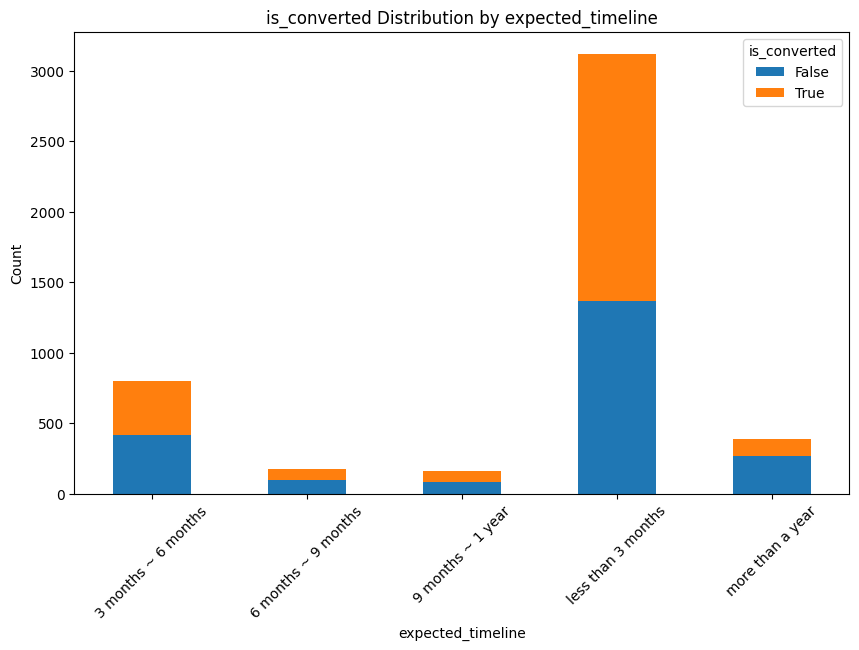

In [47]:
selected_values = ['less than 3 months', '3 months ~ 6 months', 'more than a year', '9 months ~ 1 year', '6 months ~ 9 months']
filtered_df = df_train_balanced[df_train_balanced['expected_timeline'].isin(selected_values)]

# expected_timeline과 is_converted 간의 교차 탐색 수행
cross_tab = pd.crosstab(filtered_df['expected_timeline'], filtered_df['is_converted'])

# 시각화
cross_tab.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('is_converted Distribution by expected_timeline')
plt.xlabel('expected_timeline')
plt.ylabel('Count')
plt.xticks(rotation=45)  # x축 라벨 회전
plt.legend(title='is_converted')
plt.show()

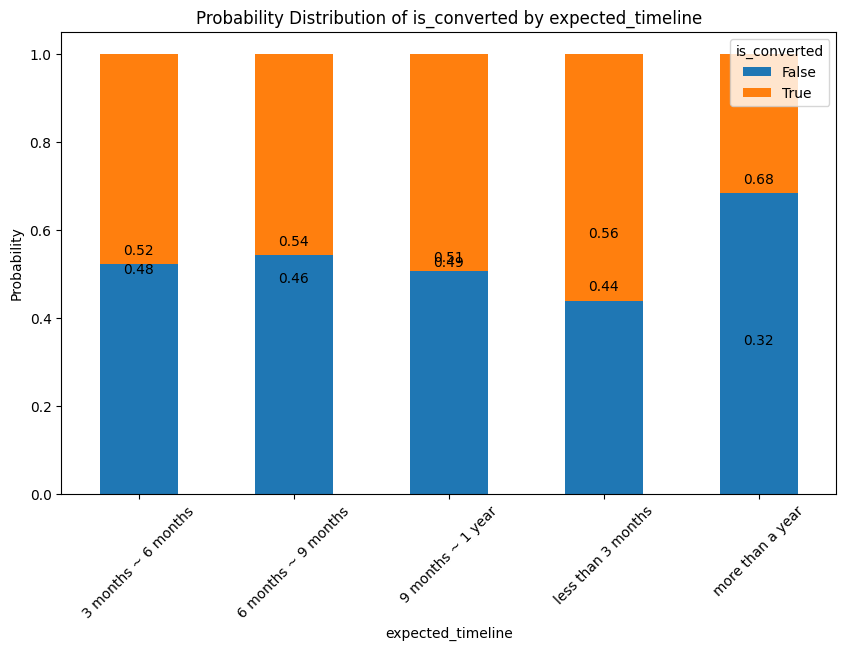

In [48]:
# expected_timeline별로 is_converted의 True와 False의 비율을 계산하여 확률로 나타내기
probabilities = cross_tab.div(cross_tab.sum(axis=1), axis=0)

# 시각화
ax = probabilities.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Probability Distribution of is_converted by expected_timeline')
plt.xlabel('expected_timeline')
plt.ylabel('Probability')
plt.xticks(rotation=45)
plt.legend(title='is_converted')

for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

## 2. 데이터 전처리

### 레이블 인코딩

In [ ]:
def label_encoding(series: pd.Series) -> pd.Series:
    """범주형 데이터를 시리즈 형태로 받아 숫자형 데이터로 변환합니다."""

    my_dict = {}

    # 모든 요소를 문자열로 변환
    series = series.astype(str)

    for idx, value in enumerate(sorted(series.unique())):
        my_dict[value] = idx
    series = series.map(my_dict)

    return series

In [ ]:
# 레이블 인코딩할 칼럼들
label_columns = [
    "customer_country",
    "business_subarea",
    "business_area",
    "business_unit",
    "customer_type",
    "enterprise",
    "customer_job",
    "inquiry_type",
    "product_category",
    "product_subcategory",
    "product_modelname",
    "customer_country.1",
    "customer_position",
    "response_corporate",
    "expected_timeline",
]

df_all = pd.concat([df_train[label_columns], df_test[label_columns]])

for col in label_columns:
    df_all[col] = label_encoding(df_all[col])

다시 학습 데이터와 제출 데이터를 분리합니다.

In [ ]:
for col in label_columns:
    df_train[col] = df_all.iloc[: len(df_train)][col]
    df_test[col] = df_all.iloc[len(df_train) :][col]

### 2-2. 학습, 검증 데이터 분리

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(
    df_train.drop("is_converted", axis=1),
    df_train["is_converted"],
    test_size=0.2,
    shuffle=True,
    random_state=400,
)

## 3. 모델 학습

### 모델 정의

In [ ]:
model = DecisionTreeClassifier()

### 모델 학습

In [ ]:
model.fit(x_train.fillna(0), y_train)

DecisionTreeClassifier()

### 모델 성능 보기

In [ ]:
def get_clf_eval(y_test, y_pred=None):
    confusion = confusion_matrix(y_test, y_pred, labels=[True, False])
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, labels=[True, False])
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred, labels=[True, False])

    print("오차행렬:\n", confusion)
    print("\n정확도: {:.4f}".format(accuracy))
    print("정밀도: {:.4f}".format(precision))
    print("재현율: {:.4f}".format(recall))
    print("F1: {:.4f}".format(F1))

In [ ]:
pred = model.predict(x_val.fillna(0))
get_clf_eval(y_val, pred)

오차행렬:
 [[ 1092   298]
 [  362 16038]]

정확도: 0.9629
정밀도: 0.7510
재현율: 0.7856
F1: 0.7679


## 4. 제출하기

### 테스트 데이터 예측

In [ ]:
# 예측에 필요한 데이터 분리
x_test = df_test.drop(["is_converted", "id"], axis=1)

In [ ]:
test_pred = model.predict(x_test.fillna(0))
sum(test_pred) # True로 예측된 개수

1351

### 제출 파일 작성

In [ ]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")
df_sub["is_converted"] = test_pred

# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)

**우측 상단의 제출 버튼을 클릭해 결과를 확인하세요**